In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

def train_net(net,train_loader,val_loader,name, num_classes=9,batch_size=64,learning_rate=0.01,num_epochs=30):
    torch.manual_seed(1000)


    criterion = nn.CrossEntropyLoss()


    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0
        total_samples = 0

        net.train()  # set to training mode

        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backprop + update
            loss.backward()
            optimizer.step()

            # Compute stats
            total_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            # Compare preds vs. labels
            total_train_err += (preds != labels).sum().item()
            total_samples += labels.size(0)

        # Average training metrics
        train_err[epoch]  = total_train_err / total_samples
        train_loss[epoch] = total_train_loss / (i + 1)

        # Evaluate on validation set
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)

        print((
            f"Epoch {epoch+1}/{num_epochs}: "
            f"Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | "
            f"Val err: {val_err[epoch]:.4f}, Val loss: {val_loss[epoch]:.4f}"
        ))

        # Save model checkpoint
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Finished Training")
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Save the train/val error/loss as CSV for plotting
    np.savetxt(f"{name}_train_err.csv",  train_err)
    np.savetxt(f"{name}_train_loss.csv", train_loss)
    np.savetxt(f"{name}_val_err.csv",    val_err)
    np.savetxt(f"{name}_val_loss.csv",   val_loss)
def evaluate(net, loader, criterion):
    net.eval()  # set to eval mode
    total_err   = 0
    total_loss  = 0.0
    total_count = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader, 0):
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            total_err += (preds != labels).sum().item()

            total_loss += loss.item()
            total_count += labels.size(0)

    err  = total_err / total_count
    loss = total_loss / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


    # Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [28]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class DigitMatrixDataset(Dataset):
    def __init__(self, root_dir, matrix_sizes=('2x2',), sources=('digits_1', 'digits_2'), transform=None):
        self.root_dir = root_dir
        self.matrix_sizes = matrix_sizes
        self.sources = sources
        self.transform = transform if transform else transforms.ToTensor()
        self.image_label_pairs = []

        for matrix_size in matrix_sizes:
            digit_dir = os.path.join(root_dir, 'cropped_digits')
            matrix_dir = os.path.join(root_dir, 'matrices')

            # Load matrix A and B
            labels_A = np.load(os.path.join(matrix_dir, f'A_{matrix_size}.npy'))
            labels_B = np.load(os.path.join(matrix_dir, f'B_{matrix_size}.npy'))

            # Collect sample folders like '2x2_0', '2x2_1', etc.
            sample_dirs = sorted([
                d for d in os.listdir(digit_dir) if d.startswith(matrix_size)
            ], key=lambda x: int(x.split('_')[1]))

            for idx, sample_name in enumerate(sample_dirs):
                sample_path = os.path.join(digit_dir, sample_name)

                for source in sources:
                    label_matrix = labels_A[idx] if source == 'digits_1' else labels_B[idx]
                    digit_path = os.path.join(sample_path, source)

                    if not os.path.isdir(digit_path):
                        continue

                    for i in range(len(os.listdir(digit_path))):
                        img_path = os.path.join(digit_path, f'image_{i}.png')
                        if not os.path.exists(img_path):
                            continue
                        label = int(label_matrix.flat[i])
                        self.image_label_pairs.append((img_path, label))

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        img_path, label = self.image_label_pairs[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [29]:
import os
os.environ["TORCH_DYNAMO_DISABLE"] = "1"
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = DigitMatrixDataset(
    root_dir='/content/drive/MyDrive/NumberData/train',
    matrix_sizes=('2x2',),
    sources=('digits_1', 'digits_2'),
    transform=transform
)

val_dataset = DigitMatrixDataset(
    root_dir='/content/drive/MyDrive/NumberData/val',
    matrix_sizes=('2x2',),
    sources=('digits_1', 'digits_2'),
    transform=transform
)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



Epoch 1/30: Train err: 0.7071, Train loss: 2.2493 | Val err: 0.5000, Val loss: 2.0285
Epoch 2/30: Train err: 0.3155, Train loss: 1.0671 | Val err: 0.2474, Val loss: 0.7178
Epoch 3/30: Train err: 0.1544, Train loss: 0.4955 | Val err: 0.1172, Val loss: 0.3919
Epoch 4/30: Train err: 0.1197, Train loss: 0.3799 | Val err: 0.0859, Val loss: 0.3171
Epoch 5/30: Train err: 0.0899, Train loss: 0.2821 | Val err: 0.0938, Val loss: 0.2889
Epoch 6/30: Train err: 0.0727, Train loss: 0.2269 | Val err: 0.0599, Val loss: 0.2015
Epoch 7/30: Train err: 0.0536, Train loss: 0.1740 | Val err: 0.0651, Val loss: 0.2401
Epoch 8/30: Train err: 0.0482, Train loss: 0.1600 | Val err: 0.0417, Val loss: 0.1890
Epoch 9/30: Train err: 0.0448, Train loss: 0.1437 | Val err: 0.0547, Val loss: 0.1861
Epoch 10/30: Train err: 0.0367, Train loss: 0.1203 | Val err: 0.0469, Val loss: 0.1666
Epoch 11/30: Train err: 0.0407, Train loss: 0.1225 | Val err: 0.0312, Val loss: 0.1243
Epoch 12/30: Train err: 0.0338, Train loss: 0.0994 |

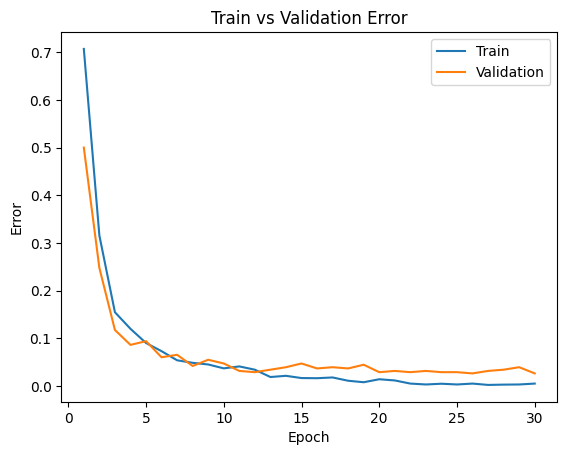

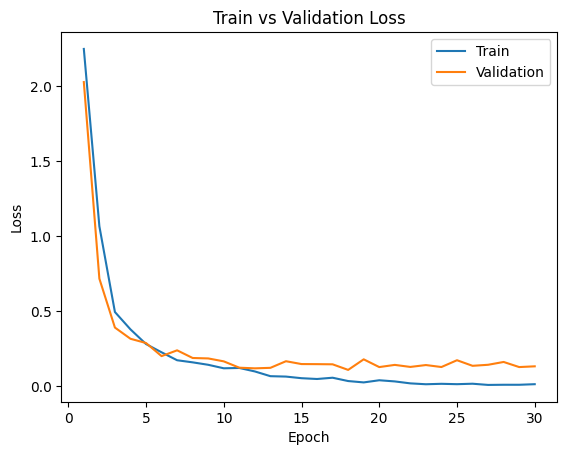

In [30]:
model = DigitNet(num_classes=10)
model.name = "DigitNet"

# Train the model using your provided training function
train_net(model, train_loader, val_loader, name="DigitNet", num_classes=10,
          batch_size=batch_size, learning_rate=0.01, num_epochs=30)

# Plot the training curves after training (requires the CSV files saved during training)
plot_training_curve("DigitNet")

In [32]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
test_dataset = DigitMatrixDataset(
    root_dir='/content/drive/MyDrive/NumberData/test',
    matrix_sizes=('2x2',),
    sources=('digits_1', 'digits_2'),
    transform=transform
)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function (criterion) as used in training/evaluation
criterion = torch.nn.CrossEntropyLoss()

# Evaluate the model on the test set using your evaluate function
test_err, test_loss = evaluate(model, test_loader, criterion)

print(f"Test Error: {test_err:.4f}, Test Loss: {test_loss:.4f}")

Test Error: 0.0312, Test Loss: 0.1347


In [ ]:
load_epoch = 24
path = f"model_DigitNet_bs64_lr0.01_epoch{load_epoch}"
loaded_model = DigitNet(num_classes=10)
loaded_model.load_state_dict(torch.load(path))
loaded_model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function (criterion) as used in training/evaluation
criterion = torch.nn.CrossEntropyLoss()

# Evaluate the model on the test set using your evaluate function
test_err, test_loss = evaluate(loaded_model, test_loader, criterion)

print(f"Test Error: {test_err:.4f}, Test Loss: {test_loss:.4f}")

<ipython-input-12-cbd3fba47a56>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path))


Test Error: 0.0096, Test Loss: 0.0389


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
class OperatorDataset(Dataset):
    def __init__(self, image_dir, label_path, prefix="2x2_op_", transform=None):
        self.image_dir = image_dir
        self.label_path = label_path
        self.prefix = prefix
        self.transform = transform

        # Collect and sort image file paths (e.g., 2x2_op_0.png, 2x2_op_1.png, etc.)
        self.image_paths = sorted(
            glob.glob(os.path.join(image_dir, f"{prefix}*.png")),
            key=lambda x: int(os.path.splitext(x)[0].split("_")[-1])
        )

        # Load labels from the .npy file
        self.labels = np.load(label_path)

        # Sanity check: ensure the number of images matches the number of labels
        assert len(self.image_paths) == len(self.labels), (
            f"Number of images ({len(self.image_paths)}) does not match "
            f"number of labels ({len(self.labels)})!"
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and convert to RGB
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Retrieve the label from the npy file
        label = self.labels[idx]
        # If label is a tuple (e.g., (operator_label, ...)), extract the first element.
        if isinstance(label, tuple):
            label = label[0]

        # If the label is a string, convert it to an integer using a mapping
        if isinstance(label, (str, np.str_)):
            operator_map = {"+": 0, "-": 1, "*": 2, "×": 2}
            label = operator_map[label]

        # Convert label to a tensor with the appropriate type
        label = torch.tensor(label, dtype=torch.long)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
import os
root_dir="/content/drive/MyDrive/MNIST_dataset_op"
train_ops_dir_2x2 = os.path.join(root_dir, "train/ops")
train_label_path_2x2 = os.path.join(root_dir, "train/operators_2x2.npy")

test_ops_dir_2x2 = os.path.join(root_dir, "test/ops")
test_label_path_2x2 = os.path.join(root_dir, "test/operators_2x2.npy")

val_ops_dir_2x2 = os.path.join(root_dir, "val/ops")
val_label_path_2x2 = os.path.join(root_dir, "val/operators_2x2.npy")

train_ops_dir_3x3 = os.path.join(root_dir, "train/ops")
train_label_path_3x3 = os.path.join(root_dir, "train/operators_3x3.npy")

test_ops_dir_3x3 = os.path.join(root_dir, "test/ops")
test_label_path_3x3 = os.path.join(root_dir, "test/operators_3x3.npy")

val_ops_dir_3x3 = os.path.join(root_dir, "val/ops")
val_label_path_3x3 = os.path.join(root_dir, "val/operators_3x3.npy")

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
batch_size = 32

# Create the training dataset for 2x2 operators
train_dataset_2x2 = OperatorDataset(
    image_dir=train_ops_dir_2x2,
    label_path=train_label_path_2x2,
    prefix="2x2_op_",
    transform=transform
)
train_loader_2x2 = DataLoader(train_dataset_2x2, batch_size=batch_size, shuffle=True)

# Create the validation dataset for 2x2 operators
val_dataset_2x2 = OperatorDataset(
    image_dir=val_ops_dir_2x2,
    label_path=val_label_path_2x2,
    prefix="2x2_op_",
    transform=transform
)
val_loader_2x2 = DataLoader(val_dataset_2x2, batch_size=batch_size, shuffle=False)

# Create the test dataset for 2x2 operators
test_dataset_2x2 = OperatorDataset(
    image_dir=test_ops_dir_2x2,
    label_path=test_label_path_2x2,
    prefix="2x2_op_",
    transform=transform
)
test_loader_2x2 = DataLoader(test_dataset_2x2, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OperatorNet(nn.Module):
    def __init__(self, num_classes=3):
        super(OperatorNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

Epoch 1/10: Train err: 0.3960, Train loss: 1.0215 | Val err: 0.3333, Val loss: 0.8135
Epoch 2/10: Train err: 0.2180, Train loss: 0.6392 | Val err: 0.0000, Val loss: 0.2858
Epoch 3/10: Train err: 0.0000, Train loss: 0.1091 | Val err: 0.0000, Val loss: 0.0061
Epoch 4/10: Train err: 0.0000, Train loss: 0.0024 | Val err: 0.0000, Val loss: 0.0004
Epoch 5/10: Train err: 0.0000, Train loss: 0.0002 | Val err: 0.0000, Val loss: 0.0002
Epoch 6/10: Train err: 0.0000, Train loss: 0.0001 | Val err: 0.0000, Val loss: 0.0001
Epoch 7/10: Train err: 0.0000, Train loss: 0.0001 | Val err: 0.0000, Val loss: 0.0001
Epoch 8/10: Train err: 0.0000, Train loss: 0.0001 | Val err: 0.0000, Val loss: 0.0000
Epoch 9/10: Train err: 0.0000, Train loss: 0.0000 | Val err: 0.0000, Val loss: 0.0000
Epoch 10/10: Train err: 0.0000, Train loss: 0.0000 | Val err: 0.0000, Val loss: 0.0000
Finished Training
Total time elapsed: 66.27 seconds


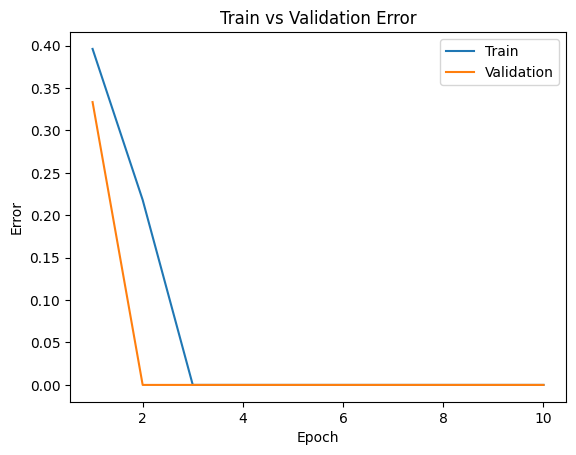

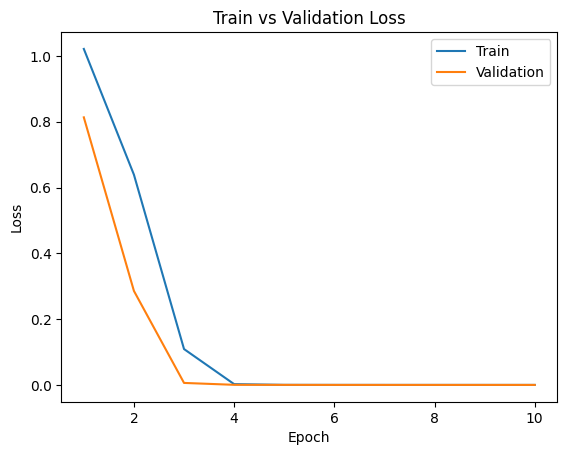

In [ ]:
operator_model = OperatorNet(num_classes=3)
operator_model.name = "OperatorNet"

train_net(operator_model, train_loader_2x2, val_loader_2x2,
          name="OperatorNet", num_classes=3,
          batch_size=batch_size, learning_rate=0.01, num_epochs=10)
plot_training_curve("OperatorNet")


In [ ]:
# Evaluate on test set
import torch
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(operator_model, test_loader_2x2, criterion)
print(f"Test Error (2×2): {test_err:.4f}, Test Loss (2×2): {test_loss:.4f}")

Test Error (2×2): 0.0000, Test Loss (2×2): 0.0000
